# A1: Unconstrained Optimization

---

*Purpose*: The simplest kind of optimization problem is one without constraints---an *unconstrained optimization* problem. We will begin our study of optimization with this simple setting.

*Learning Objectives*:
- build and explore models with Grama
- learn the first-order necessary condition (FONC) and curvature condition
- use `scipy.optimize.minimize` to optimize unconstrained problems with multiple minima
- apply these concepts to the context of Nonlinear Least Squares (NLS) model-fitting

*Reading*:
- Grama documentation, [verbs](https://py-grama.readthedocs.io/en/latest/source/language.html#verbs)
- Kochenderfer and Wheeler, Ch 1.5, 1.6, 1.7



### Assignment Checklist

1. [?] Make sure you have answered all questions. These are marked with a **qX.Y**
1. [?] Make sure you complete the Project Task at the end of the assignment. These will scaffold your project progress during the semester.
1. [?] Make sure your notebook passes all `assert()` statements. You will not get full credit for the assignment if a single `assert()` fails.
1. [?] Make sure your notebook runs: `Kernel > Restart kernel and run all cells...`
1. [?] Upload your notebook to Canvas.


### Grading Rubric

Every assignment is worth 10 points; it is not possible to receive less than 0 points. For each question (qX.Y) on a given assignment, the following grading rubric will be applied. For every NI that you receive, one point will be subtracted from your assignment total. For reference, to receive an A- in this class, you will need an average of 9 points across your 5 best assignments, meaning you need to have at most one mistake on your final submission for 5 assignments. To achieve this, you should take advantage of both the Draft and Final submission deadlines.

| Category     | Needs Improvement (NI)                     | Satisfactory (S)                       |
|--------------|--------------------------------------------|----------------------------------------|
| Effort       | qX.Y left unattempted                      | qX.Y attempted                         |
| Assertions   | Code does not pass an `assert()`           | All `assert()`s pass, or no assertions |
| Observations | Any point under *observe* left unattempted | All *observe*s attempted and correct,  |
|              | Provided an incorrect observation          | or no *observe*s for that q            |


## S1: Grama Modeling

---

[Grama](https://joss.theoj.org/papers/10.21105/joss.02462) is an [open-source](https://github.com/zdelrosario/py_grama) Python package designed to support model analysis with quantified uncertainties. We will use it throughout the course to build and analyze models.


In [1]:
import grama as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
DF = gr.Intention()

# Set figure options
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


Using Grama consists of two steps:

1. **Build** the model, which consists of functions, bounds, and densities to describe the uncertainty
1. **Analyze** the model, which can involve optimization, inference, curve-fitting, uncertainty propagation, sensitivity analysis, etc.

In order to do analysis, we first have to build the model. The following code demonstrates how to build a simple model with Grama.


In [2]:
# NOTE: No need to edit; the following demonstrates how to create a Grama model

# Define the function
def fun_example(X):
    # Name its variables
    x, y, z = X
    return (x + y) ** z
# These must match the order used above!
var_example = ["x", "y", "z"]
# Name the output(s) of the function
out_example = ["f"]

# Grama syntax is a little strange, but is designed to promote readability of code
# using *functional programming patterns* and pipes `>>`
md_example = (
    gr.Model("Example")
    >> gr.cp_function(
        fun=fun_example, # Specify the function
        var=var_example, # Name the input(s)
        out=out_example, # name the output(s)
    )
    >> gr.cp_bounds(
        x=(-1, +1),
        y=(-1, +1),
        z=(0.5, 2.0),
    )
)

# Once built, we can print a helpful summary of a Grama model
md_example.printpretty()


model: Example

  inputs:
    var_det:
      x: [-1, 1]
      z: [0.5, 2.0]
      y: [-1, 1]
    var_rand:
    copula:
        None
  functions:
    f0: ['x', 'y', 'z'] -> ['f']


The important parts of the code above:

> `gr.Model()` creates a blank Grama model

This is the starting point for creating a model. We can add things like functions, bounds on inputs, or a description of uncertainty to a model by using `comp`osition verbs.

> `gr.comp_function(md, ...)` adds a function to a Grama model

A function maps inputs to outputs; Grama models can have multiple functions.

> `>>` is the *pipe operator* in Grama

The pipe operator `>>` takes the left-hand-side and inserts it as the first argument into the right-hand-side function. So `gr.comp_function(md, ...)` can be written as `md >> gr.cp_function(...)`. We shorten the prefix `comp` to `cp` to tell Grama to use the pipe-enabled version of the verb.

> `gr.comp_bounds(...)` adds bounds for inputs to a Grama model

These are useful for specifying optimization bounds and setting nominal variable conditions.

> By specifying both *functions* and the *input space*, Grama models make sophisticated analyses very simple.

You'll get some practice using these Grama tools below.


### q1.1 Add a function

Implement the following expression as a function, and add it to the grama model below.

$$f(x, y, z) = z \cdot \exp(x + y).$$

*Hint*: Feel free to pattern-match using the example code given above. If you need more direction for this, you can [read the documentation](https://py-grama.readthedocs.io/en/latest/source/language.html#model-building) on model building.


In [3]:
###
# TASK: Implement the function above, add it to md_task below
###

# TASK: Uncomment and fill-in the `task` quantities below
def fun_task(X):
    x, y, z = X
    return z * np.exp(x + y)
#     pass
var_task = ["x", "y", "z"]
out_task = ["f"]


# TASK: Add fun_task as a function to this model
md_task = (
    gr.Model("Task model")
## YOUR CODE HERE
    >> gr.cp_function(
    fun=fun_task, # Specify the function
    var=var_task, # Name the input(s)
    out=out_task, # name the output(s)    
    )   
)

# NOTE: No need to edit this; use this to check your work
md_task.printpretty()
df_task_res = gr.eval_df(
    md_task,
    df=gr.df_make(x=+1, y=-1, z=+2)
)
assert(df_task_res[["f"]].equals(gr.df_make(f=2.0)))
print("Success!")


model: Task model

  inputs:
    var_det:
      x: (unbounded)
      z: (unbounded)
      y: (unbounded)
    var_rand:
    copula:
        None
  functions:
    f0: ['x', 'y', 'z'] -> ['f']
Success!


### q1.2 Add bounds

Add bounds from $[-1, +1]$ for `x, y, z` to the model `md_task`. If you do this correctly, the following code will produce a plot.


Calling plot_sinew_outputs....


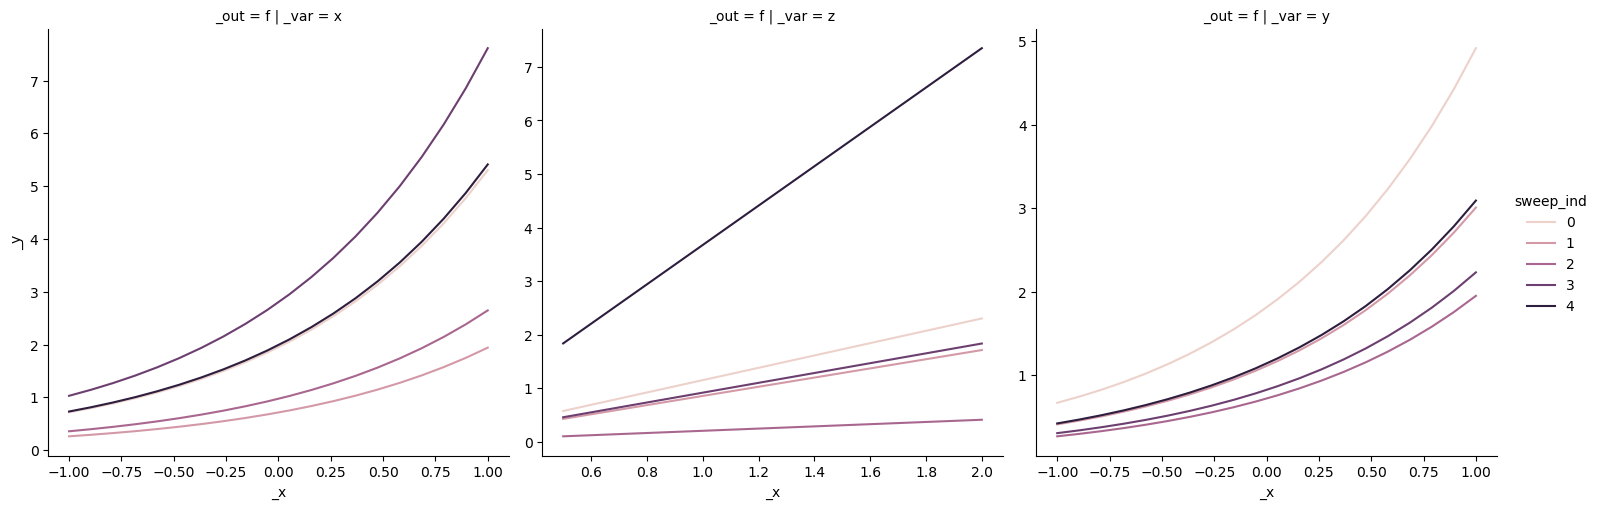

In [4]:
###
# TASK: Add bounds to x, y, z in md_task
###

# TASK: Add bounds to this model
md_task = (
    md_task
# YOUR CODE HERE
    >> gr.cp_bounds(
        x=(-1, +1),
        y=(-1, +1),
        z=(0.5, 2.0),
    ) 
)

# NOTE: No need to edit; this will construct "ceteris paribus" plots
#       for your model
(
    md_task
    >> gr.ev_sinews(df_det="swp", n_sweeps=5, n_density=20, seed=101)
    >> gr.pt_auto()
)


Once you've build a Grama model, you can use Grama verbs to carry out very sophisticated analyses with few lines of code. For instance, the code above constructs *ceteris paribus* plots for your model, which economists and machine learning researchers use to understand the effects of variables on a model. In the Case Study below we'll see how we can use Grama to do curve fitting as well.


## S2: Optimization: Necessary Conditions

---

In this section, we'll discuss the necessary conditions for *minimizing* a function. We'll also take a look at the workhorse optimization routine `scipy.optimize.minimize`.


### *Aside*: What about Maximization?

Maximizing an objective function can be trivially reformulated as minimization. If we seek to maximize a function

$$\text{max}\, y(x)$$
$$\text{wrt.}\, x$$

Then we can formulate it as

$$\text{min}\, -y(x)$$
$$\text{wrt.}\, x$$

For this reason `scipy` only implements a `minimize` routine; you'll need to negate your objective if you want to do maximization!


## Running Example

For this section we'll consider a running example:

$$f = \sin(3/2 \pi x) + x^2$$

The following code implements this function and visualizes it across an interval.


Text(0, 0.5, 'Objective')

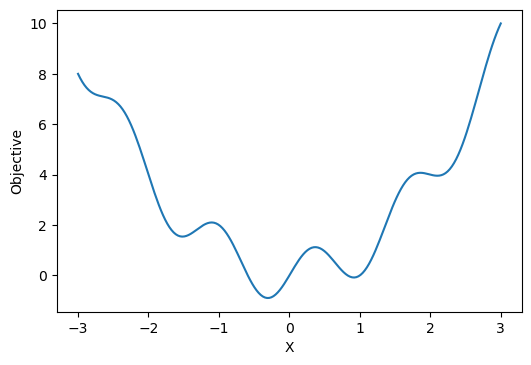

In [5]:
# NOTE: No need to edit, this code sets up the objective function
fun_multi = lambda x: np.sin(1.5 * np.pi * x) + x**2
md_multi = (
    gr.Model() 
    >> gr.cp_function(
        fun=fun_multi,
        var=["x"],
        out=["f"],
    )
)

# Compute data
X_multi = np.linspace(-3, +3, num=200)
F_multi = list(map(fun_multi, X_multi))
df_multi = gr.df_make(x=X_multi, f=F_multi)

# Visualize
plt.figure()
plt.plot(df_multi.x, df_multi.f)

plt.xlabel("X")
plt.ylabel("Objective")


## First-Order Necessary Condition (FONC)

The first-order necessary condition for optimality is that the gradient of the objective function equals zero, that is $\nabla f(x) = 0$.

As we'll see below, this alone is a *necessary*, but *not sufficient* condition for optimality.


### q2.1 Compute the derivative to apply the FONC

Derive the gradient of the function above and answer the questions below.


[-1.5180988872260528, -1.1034240867093805, -0.3057212279165902, 0.3664737016730083, 0.9153335881075773, 1.8596973462896533, 2.099898096348941]


Text(0, 0.5, 'Objective')

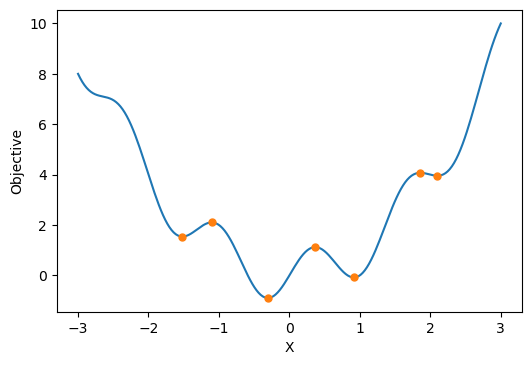

In [6]:
###
# TASK: Derive the gradient (derivative) of the function above,
#       implement it as a function.
###

fun_prime = lambda x: 2*x + (3*np.pi/2)*np.cos(3*np.pi/2*x)


# NOTE: No need to edit, this will visualize your result
# Apply FONC via root-finding routine (Newton's method)
X_roots = list(map(
    lambda x0: sp.optimize.newton(fun_prime, x0),
    [-1.5, -1, -0.5, 0.5, 1, 1.5, 2.1]
))
print(X_roots)
F_roots = list(map(fun_multi, X_roots))

plt.figure()
plt.plot(X_multi, F_multi)
plt.plot(X_roots, F_roots, '.', MarkerSize=10)
    
plt.xlabel("X")
plt.ylabel("Objective")


*Observe*:

- Does every point satisfying the FONC correspond to a "low" point on the objective function? (yes or no) 
  - No, some of the points are local maximums. 
- Provide an example of a point `x` with $f'(x) = 0$ that is not a "low" point on the function.
  - $x = -1.10, .367, 1.86$
- How does the curvature of the function relate to whether a point is a minimum or a maximum?
  - If the curvature is positive the point is a minimum. If the curvature is negative the point is a maximum. If there is no curvature the point is at an inflection or plateau. 


## Positive Curvature

The other necessary condition for minimality is that the hessian of the objective function (its second-derivative matrix) is [positive-definite](https://en.wikipedia.org/wiki/Definite_symmetric_matrix). This condition is a higher-dimensional analogue to having positive curvature, and it is denoted mathematically by $\nabla^2 f \succ 0$ (note $\succ$ rather than $>$).

The Hessian is the matrix of mixed second-order partial derivatives, that is

$$[\nabla^2 f]_{ij} = \frac{\partial^2 f}{\partial x_i \partial x_j}.$$

In the case where $x$ is one-dimensional (where there is only one scalar value for curvature), the hessian reduces to the familiar second derivative. The higher-dimensional case of the SONC essentially demands that "all" of the curvatures (in "every dimension") must be positive.

In order for a point to be a "low point", it needs to satisfy both the FONC and have positive curvature. These together are *sufficient* conditions for a point to be what we call a *local minimum*.


### q2.2 Compute the 2nd derivative to apply the positive curvature condition

Derive the second derivative of the function above, implement it, and answer the questions below.


[-1.5180988872260528, -0.3057212279165902, 0.9153335881075773, 2.099898096348941]


Text(0, 0.5, 'Objective')

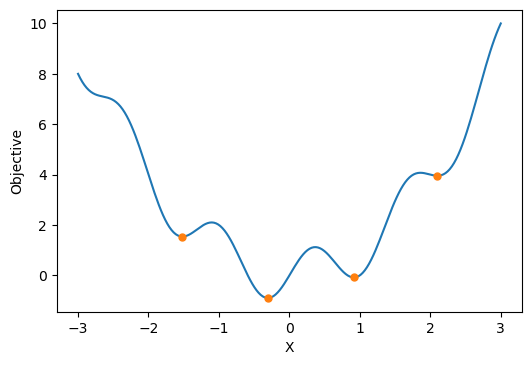

In [7]:
###
# TASK: Derive the second derivative of the function above,
#       implement it as a function.
###

fun_curvature = lambda x: 2 - (3*np.pi/2)**2*np.sin(3*np.pi/2*x)


# NOTE: No need to edit, this will visualize your result
# Apply curvature check to filter points
X_min = list(filter(
    lambda x: fun_curvature(x) > 0, 
    X_roots
))
F_min = list(map(fun_multi, X_min))
print(X_min)
plt.figure()
plt.plot(X_multi, F_multi)
plt.plot(X_min, F_min, '.', MarkerSize=10)
    
plt.xlabel("X")
plt.ylabel("Objective")


*Observe*:

- Do each of the local minima (visualized as dots above) have the same Objective function value? (yes or no)
  - yes
- Is there one local minimum that seems to have the *smallest* Objective function value? If yes, roughly what $x$ value achieves that smallest value?
  - $x= -.3057$
- Are the FONC and positive curvature conditions together *sufficient* to guarantee the smallest objective function value (as opposed to a "locally-smallest" value)? (yes or no)
  - no


### Some key terminology

Given a function $f(x)$:

- A *minimizer* of a function is a point $x^*$ that satisfies both the FONC $\nabla f(x^*) = 0$ and positive curvature $\nabla^2 f(x^*) \succ 0$.
- A *minimum* of a function is a function value $f^*=f(x^*)$ associated with a minimizer $x^*$.

Keep in mind that a *minimum* is a function value, while a *minimizer* is a point in the function's domain; they'll generally have different units and different dimensionality!

- A *global minimum* is the smallest value $f^*$ that $f(x)$ takes over its entire domain; functions that are *unbounded below* have a global minimum of $-\infty$. 
  - Similarly a *global minimizer* is a point $x^*$ that achieves the global minimum value. 
- A *local minimum* is any function value $f^*$ where the FONC and positive curvature conditions are met; a local minimum can also be the global minimum. 
  - Similarly a *local minimizer* is any point $x^*$ that achieves a local minimum value. There can be multiple, distinct *global minimizers*, but only one *global minimum*.

Full disclosure: These are *formal definitions* from optimization theory. While it's useful to know these definitions, we generally can't use them alone to solve practical optimization problems. Instead, we use an *optimization algorithm*.


## Iterative Optimization Algorithms

In this class we'll primarily talk about *using* optimization, not *developing optimization algorithms*. However, it's important to understand some basics about how most optimization algorithms work.

Most **iterative optimization** algorithms start with an initial guess $x_0$ and attempt to "improve" the function value $f(x_i)$ by searching for a new point $x_{i+1}$ where the value is lower $f(x_{i+1}) < f(x_i)$. The most intuitive approach is [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent), where we "follow" the function gradient downhill ($-\nabla f$) until we stop moving. There is a veritable zoo of optimization algorithms that are much more efficient than gradient descent, but most tend to start with an initial guess and "run downhill".

The following code runs `scipy.optimize.minimize` on our running example `fun_multi`. The `minimize` routine takes a function to optimize $f$ and an initial guess $x_0$. It then "marches" towards a local minimum of the function. Note that `minimize` returns an output *object* (call it `res`), and that we can access its minimizer with `res.x` and minimum with `res.fun`.

Given what we've seen above, it should make sense that **the inital guess strongly affects where iterative optimization ends**.


### q2.3 How does an optimization algorithm behave?

The following code picks a set of inital guesses $x_0$ and runs `minimize` for each one. Run the following code and answer the questions below.


Text(0, 0.5, 'Objective')

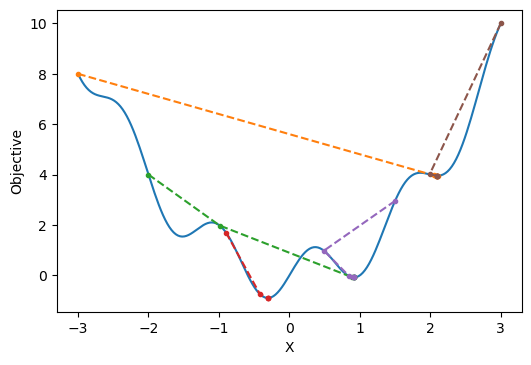

In [8]:
# NOTE: No need to edit, run and inspect
# Run optimizer with several restarts
df_hist = pd.DataFrame()
x_starts = [-3, -2, -0.9, 1.5, 3]
for i, x in enumerate(x_starts):
    # Setup callback for storing historyw
    x_hist = [x]
    f_hist = [fun_multi(x)]
    def callback(Xi):
        global x_hist, f_hist
        x_hist.append(Xi)
        f_hist.append(fun_multi(Xi))
        
    # Minimize
    res = sp.optimize.minimize(fun_multi, [x], callback=callback)
    xs = res.x
    fs = res.fun
    
    # Store results
    df_tmp = gr.df_make(x=x_hist, f=f_hist, i=i)
    df_hist = pd.concat((df_hist, df_tmp), axis=0)

# Visualize
plt.figure()
plt.plot(X_multi, F_multi)
for i, x in enumerate(x_starts):
    df_tmp = df_hist >> gr.tf_filter(DF.i==i)
    plt.plot(df_tmp.x, df_tmp.f, '.--')
    
plt.xlabel("X")
plt.ylabel("Objective")

Every distinct color represents the optimization *trajectory* (set of $x_i$) of a distinct initial guess.

*Observe*:

- Does every initial guess arrive at the same minimizer? (yes or no)
  - no
- Does every initial guess arrive at it nearest minimum? (yes or no)
  - no
- Do different initial guesses **sometimes** arrive at the same local minimum? (yes or no)
  - yes
- In this case we are able to *visually identify* which minimum is the global minimum. Imagine we had a function with 100 input variables. Would we be able to use the same approach to *verify* a given local minimum is the global minimum? (yes or no) Why or why not?
  - If we were relying on our actually eyes, we would run out of dimensions to visualize the function, making it pretty much impossible to verify that a local minimum is a global minimum. If you are visualizing the function using a computer, this method would probably work but it would be extremely resource intensive. 


These results suggest that we need to use iterative optimization algorithms with *caution*. The following heuristic is a good rule-of-thumb:

**Heuristic**: When seeking to minimize a function with an iterative algorithm, it is a good idea to test **multiple starting values** $x_0$ and check whether they arrive at the same minimizer $x^*$. The more trajectories that terminate at the same minimizer $x^*$ (with the smallest observed minimum value), the more credibility that point has as the possible global minimum of the objective function.

If all points arrive at the same minimizer $x^*$ then there is *no evidence* for local minima: Note that this does **not** prove that there are no local minima, only that we don't have evidence for other minima!

If distinct starting points arrive at different minimizers $x^*$ then we have clear evidence for the presence of local minima. Depending on your application you might be ok with this outcome. If multiple minima are unacceptable, it is sometimes possible to *reformulate* the problem to remove multiple minima; we'll see an example of this in the case study below.


### q2.4 Optimizing a function

Use `sp.optimize.minimize` to search for the global minimum of the following function. Document your results from multiple restarts.

*Hint*: Keep in mind that in Jupyter you can look up the documentation for a function by placing your cursor on the function and pressing `Shift + Tab`. This is useful for looking up the arguments of a function and understanding the structure of its output. For instance, if you set `res = sp.optimize.minimize(...)`, then you should unpack the appropriate attribute of `res` to `x_s = res.something`.


global min 3.152244340370053e-16
global min pos [1.         0.99999999]
x_s = [1.         0.99999999]
Your f_s is 3.152244340370053e-16 above the global minimum



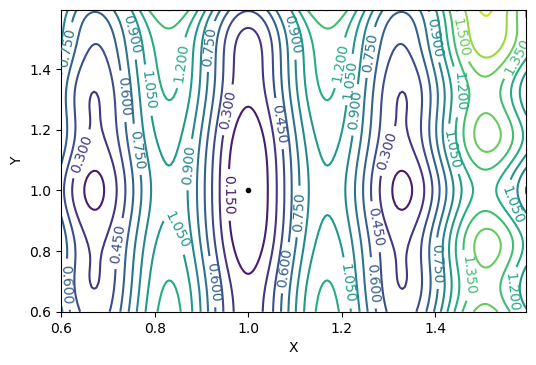

In [9]:
###
# TASK: Use scipy.optimize.minimize to minimize the following function.
###
import random
# NOTE: No need to edit; find the minimum of this function
def fun_2d(X):
    """Levi's function"""
    x, y = X
    
    return np.sin(3 * np.pi * x)**2 + \
        (x - 1)**2 * (1 + np.sin(3 * np.pi * y)**2) + \
        (y - 1)**2 * (1 + np.sin(2 * np.pi * y)**2)

# TASK: Use sp.optimize.minimize to search for the minimum of the function

min_xs = []
min_value = []
for i in range(100):
    res = sp.optimize.minimize(fun_2d, [random.uniform(.6,1.6),random.uniform(.6,1.6)])
    min_xs.append(res.x)
    min_value.append(res.fun)

global_min = np.min(min_value)
print("global min", global_min)
x_s = min_xs[min_value.index(global_min)]
print("global min pos", x_s)





# NOTE: No need to edit; this visualizes your result
delta = 5e-3
x = np.arange(0.6, 1.6, delta)
y = np.arange(0.6, 1.6, delta)
X, Y = np.meshgrid(x, y)
Z = np.zeros((len(X), len(Y)))
for i, x in enumerate(X):
    for j, y in enumerate(Y):
        Z[i, j] = fun_2d([X[i, j], Y[i, j]])
        
# Create contour plot
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z, levels=15)
ax.plot(x_s[0], x_s[1], "k.")

ax.clabel(CS, inline=1, fontsize=10)
plt.xlabel("X")
plt.ylabel("Y")

# Check optimized value
f_s = fun_2d(x_s)
print("x_s = {}".format(x_s))
print("Your f_s is {} above the global minimum".format(f_s))
print()


*Observe*:

- How far is your identified minimum above the global minimum? Is it greater than zero? (See the text printout above.)
  - My identified minimum is around 10^-15 above the global minimum (0). While this may not be zero, it is very, very close to zero and for all practical contexts can be assummed to equal 0, or in our case, the global minimum.
- Aside from the "above the minimum" value reported (which you would *not* have in practice), what evidence do you have that your minimum is the global minimum?  Does this *prove* that your minimum is the global minimum?
  - I can say fairly confidently that my heursitic approach returned the global minimum of this function within the provided plot range. This is only because I ran 100 iterations of the minimize function with random starting positions and returned the position that generated the smallest value. 


Multiple minima is not some abstract issue; it shows up in **real** engineering problems, as we'll see below.

## S3: Case Study: Least Squares Regression

---

Often we have some model for a physical system with *unknown parameters*. We can combine data with [least squares regression](https://en.wikipedia.org/wiki/Non-linear_least_squares) to *fit* the model---that is, optimize the agreement of the model with data to find optimal parameter values. This is a very common use of optimization, but the issue of multiple minima can make model fitting very difficult.

To illustrate, let's take a look at a case study involving the frequency response of a circuit. An LC circuit starting with initial voltage difference $V_0$ has the following current waveform:

$$i_{\text{true}}(t, \theta) = \sqrt{C/L} V_0 \sin(\sqrt{1/(LC)} \cdot t)$$

where $\theta = [V_0, C, L]$ is the vector of *parameters* for the model. We further assume that the true current value is corrupted by additive noise:

$$i_{\text{meas}}(t, \theta) = i_{\text{true}}(t) + \epsilon_{\text{noise}}$$

The following code plots this wave.


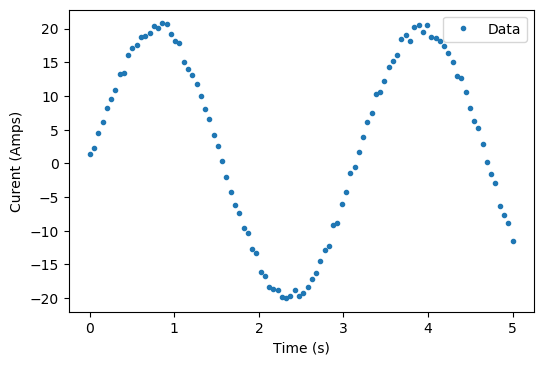

In [10]:
# NOTE: No need to edit; this creates and visualizes our data
np.random.seed(101)
n = 100
df_data = (
    gr.df_make(t=np.linspace(0, 5, num=n))
    >> gr.tf_mutate(i_true=20 * gr.sin(2 * DF.t))
    >> gr.tf_mutate(
        i=DF.i_true + np.random.normal(size=n, scale=0.5)
    )
)

# Visualize
plt.figure()
plt.plot(df_data.t, df_data.i, '.', label="Data")

plt.xlabel("Time (s)")
plt.ylabel("Curent (Amps)")
plt.legend(loc=0)


### Application of NLS to Circuit Analysis

The expression $i_{\text{true}}(t, \theta)$ above is a parameterized function that we can fit with [Non-linear least squares](https://en.wikipedia.org/wiki/Non-linear_least_squares) (NLS). NLS formulates an objective function for this fitting based on the *mean squared error* (MSE)

$$\text{MSE}(\hat{\theta}) = \frac{1}{n}\sum_{i=1}^n (i_{\text{true}}(t_i, \hat{\theta}) - i_{\text{measured}}(t_i, \theta_{\text{true}}) )^2$$

Our assumption in NLS is that there exist some "true" parameter values $\theta_{\text{true}}$, and we seek to optimize $\hat{\theta}$ so as to minimize the MSE and recover the true parameters $\theta_{\text{true}}$. **Importantly** unless there is special structure in our parameterized function, there is no guarantee that there exists a single "best" parameter value $\hat{\theta}^*$ that minimizes the MSE. This can lead to multiple minima, as we'll see below.

Given all this, we can formulate NLS as an optimization problem:

$$\min\, \text{MSE}(\hat{\theta})$$
$$\text{wrt.}\, \hat{\theta}$$

In this case study we'll apply NLS to the circuit waveform. We'll break this down into steps:


### q3.1 Implement the signal function

Implement the function

$$i_{\text{true}}(t, \theta) = \sqrt{C/L} V_0 \sin(\sqrt{1/(LC)} \cdot t)$$

as a Python function.


In [11]:
###
# TASK: Implement the signal as a function
###

# NOTE: No need to edit this variable list
var_signal = ["t", "C", "L", "V0"]

def fun_signal(X):
    t, C, L, V0 = X
    return np.sqrt(C/L)*V0*np.sin(np.sqrt(1/(L*C))*t)


# NOTE: No need to edit; use this to check your work
F = gr.Function(
    fun_signal,
    var_signal,
    ["i"],
    "Signal",
    0,
)
df_res = F.eval(gr.df_make(t=np.pi, C=0.25, L=1, V0=1))
assert(abs(df_res.i[0]) < 1e-15)

print("Success!")


Success!


Grama contains a routine `fit_nls()` that performs NLS automatically: It takes a dataset and a parameterized model, formulates the MSE objective, and runs `minimize` to find an optimal parameter value. To use `fit_nls()`, you must create a Grama model.

### q3.2 Implement the signal as a Grama model

Add your function to the following Grama model.


In [12]:
###
# TASK: Add the function you implemented above to the following model
###

# NOTE: No need to edit
md_signal = (
    gr.Model("Signal")
## TODO: Add your function from q3.1 here
    >> gr.cp_function(
        fun=fun_signal,
        var=var_signal,
        out=["i"],
    )

## NOTE: No need to change these bounds
    >> gr.cp_bounds(
        V0=(-10, 40),
        C=(0.1, 1),
        L=(0.5, 1.5),
    )
)

## NOTE: No need to edit; this will run NLS on your Grama model
md_fit1 = gr.fit_nls(
    df_data,
    md=md_signal,
    uq_method="linpool",
    seed=101,
)


... fit_nls setting out = ['i']
... eval_nls setting out = ['i']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']
          L         C        V0  L_0   C_0  V0_0  success  \
0  0.509289  0.109234 -3.604877  1.0  0.55  15.0     True   

                                             message  n_iter         mse  
0  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPS...      11  188.887635  
... provided columns intersect model output.
eval_df() is dropping {'i'}


In [13]:
V0 = -3.6
L = .51
C = .11

print(np.sqrt(C/L)*V0)
print(np.sqrt(1/(L*C)))

-1.6719133104461663
4.222003309207491


*Observe*:

- What does the `success` column of the output indicate? What does this tell you about the optimization of the squared-error? Does this guarantee the `mse` reached the *global* minimum?
  - Success indicates that the algorithim was able to converge on a result that created a minimzed `mse` value. This does not guarantee that the `mse` it converged on is the global minimum.
- The output reports both the initial guess parameters (e.g. `V0_0`) and their optimized values (e.g. `V0`). Inspect these values and compare them against the original data. Are these values reasonable?
  - These values are not reasonable. While the frequency value is somewhat close to the original (pred: 4.2 actual: 5), the amplitude is very off (pred: -1.7 actual: 20).
- Compare the initial guess parameter values to the bounds set in `cp_bounds()` above; how are they related?
  - The initial guess parameters fall almost halfway between the upper and lower bounds. 
- Try commenting out the bounds in the model definition above. What happens?
  - *Note*: Comment syntax in Python uses a hash symbol `#`
  - `ValueError: all variables to be fitted must finite nominal value
offending var = ['L', 'V0', 'C']`
- Do you get a `Warning` from `fit_nls()`? What does this warning say?
  - `Warning: Model is locally unidentifiable as measured by the condition number of the pooled covariance matrix; kappa = 1.9144497202076362e+17`


The `fit_nls()` routine returns a new Grama model with the parameters "frozen" to the optimal value. Thus you can evaluate this new model to make predictions.

It is good practice when performing NLS to not only check the MSE, but to also visually inspect the fit.

### q3.3 Visually inspect the fit

Use the Grama verb `eval_nominal()` to evaluate the fitted model `md_fit1` at the time points in the dataset `df_data`. Answer the questions below.


... provided columns intersect model output.
eval_df() is dropping {'i'}


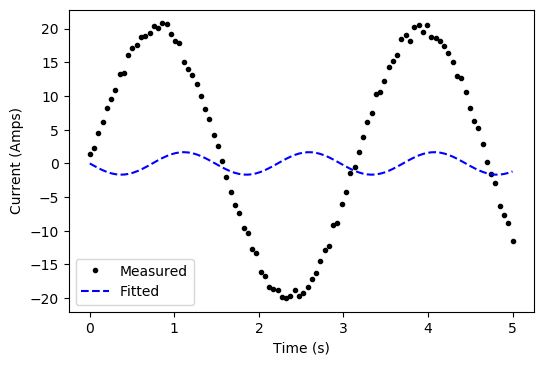

In [14]:
###
# TASK: Evaluate the fitted model at its nominal conditions
###

## TASK: Use gr.eval_nominal() to evaluate md_fit1
##       at the given time points df_data
df_res1 = md_fit1 >> gr.ev_nominal(df_data)


# NOTE: No need to edit, this will visualize your results
plt.figure()
plt.plot(df_data.t, df_data.i, 'k.', label="Measured")
plt.plot(df_res1.t, df_res1.i, 'b--', label="Fitted")

plt.xlabel("Time (s)")
plt.ylabel("Current (Amps)")
plt.legend(loc=0)


*Observe*:

- **Qualitatively**, how does your `Fitted` signal compare with the `Measured` signal: well or poorly?
    - Poorly, the fitted model seems to have a higher frequency and much lower amplitude. 
- What **specific features of the `Fitted` signal** do not match?
     - The fitted model seems to have a higher frequency and much lower amplitude. 
- Did the fitting with `fit_nls()` above have `success == True`? In what sense is a result with `success == True` optimal? What does this tell you about the relationship between a "successful" optimization of the squared-error and the quality of a fit?
    - Yes, success=True only means that the algorithm was able to achieve optimization on the local level (based on the initial conditions). It does not guarantee that the algorithm choose the absolute best variables.


As we saw in Section 2 above, *multiple starting points* can help us overcome issues of local minima. The `fit_nls()` routine has a keyword argument to automatically use a user-specified number of restarts, drawn randomly from the model bounds.

### q3.4 Use multiple restarts

Consult the documentation for `fit_nls()` (remember `Shift + Tab`) and re-run `fit_nls()` with multiple restarts. Answer the questions below, then move on to the next code chunk to visually inspect your fit.

*Hint*: Using an appropriate number of restarts, it is possible to get a *very accurate* fit!


In [15]:
### 
# TASK: Re-fit the model with fit_nls() using multiple restarts
# HINT: Read the documentation for fit_nls() to find a keyword argument
#       to control the number of restarts.
###

## TASK: Re-fit the model using at least 5 restarts
md_fit2 = gr.fit_nls(
    df_data,
    md=md_signal,
    uq_method="linpool",
    seed=101,
    n_restart=5,
)



... fit_nls setting out = ['i']
... eval_nls setting out = ['i']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']
Design runtime estimates unavailable; model has no timing data.
          L         C         V0       L_0       C_0       V0_0  success  \
1  0.503175  0.496438  20.160251  1.016399  0.125627  18.533379     True   
4  0.500000  0.499591  20.033026  0.689939  0.416919  17.711380     True   
2  0.500104  0.233111  -5.650689  0.671522  0.850507  24.263849     True   
3  0.506179  0.109906  -3.582850  0.806966  0.749389  34.680654     True   
0  0.509289  0.109234  -3.604877  1.000000  0.550000  15.000000     True   

                                             message  n_iter         mse  
1  b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_P...      13    0.272559  
4  b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_P...      18    0.272559  
2  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPS...       9  182.670282  
3  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FA

*Observe*:

- How does the `fit_nls()` report differ from the results in q3?
  - They are much closer aligned (almost identical) to the original, input values (20 for amplitude, 5 for frequency).
- How do the optimized MSE values compare across the multiple restarts? Which set of optimized parameters do you think `fit_nls()` returns?
  - The `mse` continues to drop through multiple restarts. The alogrithm most likely returns the set with the smallesst `mse` value. 
- Do you see multiple distinct restarts arrive at the same minimizing parameter value? What does this indicate about the fit?
  - While multiple distinct restarts reaching the same value should suggest that the fit is the most optimum. However, with a small set n=5 of runs, the minimizing parameters with the most arrivals happen to not coincide with the smallest `mse`. 
- Do you still get a `Warning` from `fit_nls()`? (yes or no)
  - yes

... provided columns intersect model output.
eval_df() is dropping {'i'}


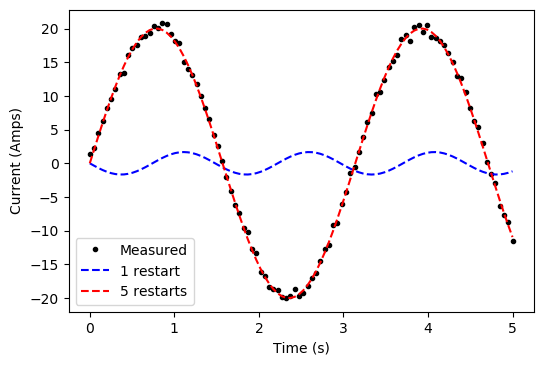

In [16]:
###
# TASK: Visually inspect the results of your new fit
###

## TASK: Evaluate your model at its nominal conditions, 
##       visualize the fit against the measured data
df_res2 = md_fit2 >> gr.ev_nominal(df_data)
# NOTE: No need to edit, this will visualize your results
plt.figure()
plt.plot(df_data.t, df_data.i, 'k.', label="Measured")
plt.plot(df_res1.t, df_res1.i, 'b--', label="1 restart")
plt.plot(df_res2.t, df_res2.i, 'r--', label="5 restarts")

plt.xlabel("Time (s)")
plt.ylabel("Current (Amps)")
plt.legend(loc=0)


... provided columns intersect model output.
eval_df() is dropping {'i'}


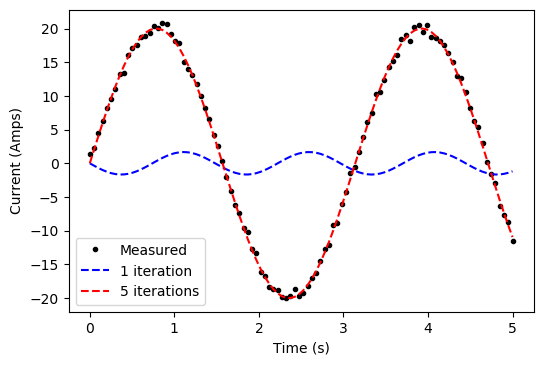

In [17]:
###
# TASK: Visually inspect the results of your new fit
###

## TASK: Evaluate your model at its nominal conditions, 
##       visualize the fit against the measured data


df_res2 = md_fit2 >> gr.ev_nominal(df_data)


# NOTE: No need to edit, this will visualize your results
plt.figure()
plt.plot(df_data.t, df_data.i, 'k.', label="Measured")
plt.plot(df_res1.t, df_res1.i, 'b--', label="1 iteration")
plt.plot(df_res2.t, df_res2.i, 'r--', label="5 iterations")

plt.xlabel("Time (s)")
plt.ylabel("Current (Amps)")
plt.legend(loc=0)


### Unidentifiability and Local Minima

The `fit_nls()` routine keeps warning us that the model is "locally unidentifiable"; what does this mean? To explain, let's evaluate the circuit model at two *completely different* parameter vectors:


... provided columns intersect model output.
eval_df() is dropping {'i'}
... provided columns intersect model output.
eval_df() is dropping {'i'}


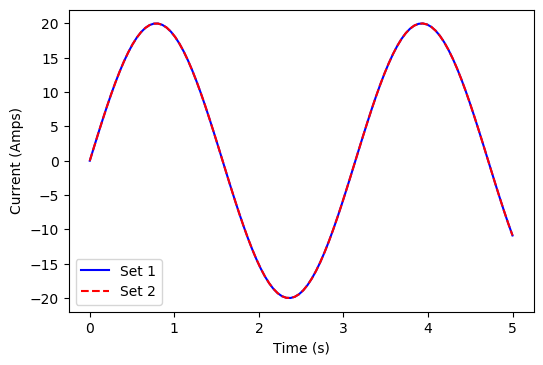

In [18]:
# NOTE: No need to edit; run and inspect
df_test1 = gr.eval_df(
    md_signal,
    df=gr.tran_outer(df_data, gr.df_make(V0=20, L=0.5, C=0.5))
)
# NOTE: The following evaluates the signal model 
#       at **distinct** parameter values
df_test2 = gr.eval_df(
    md_signal,
    df=gr.tran_outer(df_data, gr.df_make(V0=40, L=1.0, C=0.25))
)

# Visualize both evaluations of the Signal model
plt.figure()
plt.plot(df_test1.t, df_test1.i, 'b-', label="Set 1")
plt.plot(df_test2.t, df_test2.i, 'r--', label="Set 2")

plt.xlabel("Time (s)")
plt.ylabel("Current (Amps)")
plt.legend(loc=0)


These two models lie **exactly** on top of each other, despite having different parameter values! This is what it means for a model to be [unidentifiable](https://en.wikipedia.org/wiki/Identifiability)---we cannot distinguish between different parameter values.

There are various ways to solve issues of identifiability; one way is to use some independent source of information to *fix* one of the parameters and leave it out of the fitting procedure.


### q3.5 Fix a parameter

Recall that $V_0$ is the initial voltage difference across the circuit. Suppose we know that `V0 == 20` Volts for the experiment that generated our data. Override the bounds of the model to constrain the value of `V0` to `20`, re-fit the new model, and answer the questions below.


In [19]:
###
# TASK: Override the bounds of the waveform model to fix V0
###

## TASK: Freeze the V0 parameter by setting new bounds
# md_freeze = ???
## TASK: Fit the new "frozen" model
# md_fit3 = gr.fit_nls(...)

###
# TASK: Add the function you implemented above to the following model
###

# NOTE: No need to edit
md_signal = (
    gr.Model("Signal")
## TODO: Add your function from q3.1 here
    >> gr.cp_function(
        fun=fun_signal,
        var=var_signal,
        out=["i"],
    )

## NOTE: No need to change these bounds
    >> gr.cp_bounds(
        V0=(20,20),
        C=(0.1, 1),
        L=(0.5, 1.5),
    )
)

## NOTE: No need to edit; this will run NLS on your Grama model
md_fit3 = gr.fit_nls(
    df_data,
    md=md_signal,
    uq_method="linpool",
    seed=101,
    n_restart=5,
)


... fit_nls setting out = ['i']
... eval_nls setting out = ['i']
... eval_nls setting var_fix = ['V0']
... eval_nls setting var_feat = ['t']
Design runtime estimates unavailable; model has no timing data.
          L         C       L_0       C_0  success  \
3  0.500000  0.499635  1.185277  0.850507     True   
2  0.500000  0.499635  0.528474  0.254369     True   
4  0.787807  0.100000  0.806966  0.904252     True   
0  0.500000  0.100000  1.000000  0.550000     True   
1  0.500000  0.100000  1.016399  0.613601     True   

                                             message  n_iter         mse  
3  b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_P...      14    0.273060  
2  b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_P...      15    0.273060  
4  b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_P...       4  199.929370  
0  b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_P...       1  236.175005  
1  b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_P...       1  236.175005  
... provided columns

*Observe*:

- With this "frozen" model, do you see multiple distinct restarts arrive at the same minimizer? What does this indicate about the optimization of the squared-error? Does this *guarantee* that your minimizer is the global minimizer?
  - There are several cases where multiple restarts arrive at the same minimizer (at least in my original run): runs 0 & 1 as well as runs 3 & 4. Because the majority of n_restarts in our set of 5 did not end up on the same minimizers, I would not be confident (from these results alone) that we have found the global minimizers. If the number of restarts was increased by an order of magnitude or more and a clear majority of those restarts fell on the same minimizers, I would be more confident that we found the true global minimizers. In general, we can increase the likehold of finding global minimizrs by increasing the amount of n_restarts. 


## Project

---

### __Project Task__

Look back on your project idea from the previous assignment. As we saw in this assignment, local minima can stymie optimization success. This project task will help you connect these ideas to your project.

*Task*: Provide an answer to each point below:

I am thinking of changing my project to some circuit optimization project like: optimizing the ripple voltage on the output of a buck converter while minimizing costs. 

- *Optimization objective*: What objective(s) are you seeking to optimize? How well can you formulate those mathematically? (If not, feel free to state "no change".)
  - minimize voltage ripple
  - minimize part count
  - minimize costs
- *Presence of local minima*: Does your problem have any *mathematically provable structure* that would guarantee the absence of local minima?
  - I am not sure.
  - *Note*: If you do not have provable, mathematical structure in your problem (e.g. convexity of the objective) then your problem may have *local minima*. Most problems do **not** have such structure!
- *Sources of local minima*: Are there potential sources of local minima in your project?
  -  Given that there are multiple variables (inductance, capacitance, switching freq, etc) that can determine the ripple voltage, I would assume that are potential sources of local minima.
  - *Note*: You can often use discipline-specific knowledge to help identify potential sources of local minima. As we saw above `L, C` combine to define the natural frequency of a circuit $\omega_0$. If your problem depends on *products* or *ratios* of physical quantities, then this is a likely mechanism for local minima in your problem.
- *Potential reformulation of your problem*: If you identified sources of local minima above, can you reformulate your problem to avoid these issues?
  - I could set certain variables to fixed values (capicitance, switching frequency).
  - *Note*: One way to reformulate a model is to re-express the model in terms of a smaller parameter set. For example if two geometries enter into a problem `L, W` only as an aspect ratio `AR = L/W`, then you can replace both `L, W` with `AR` alone. 
  - *Note*: If you can *fix* one of the variables in your optimization (as we did with the NLS case study above), this is another way to "solve" issues of local minima.
- *Computational tractability of multiple restarts*: Will it be *computationally tractable* to run multiple restarts of your model? 
  - There should be software like LTspice that would make it possible to run multiple restarts.
  - *Note*: If you are using an expensive simulation (e.g. FEA) this may not be possible.
